In [1]:
!pip -q install datasets transformers summa nltk SentencePiece transformers[torch] torch matplotlib seaborn


In [2]:
import os
import re
import nltk
import torch
import gensim
from datasets import load_dataset, load_from_disk
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
from summa.summarizer import summarize
from summa import keywords
nltk.download('punkt')
from nltk.tokenize import sent_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
model_name = "bert-base-uncased"

In [4]:
# BERT Setup

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
torch.cuda.set_device(0)
model.to('cuda')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [6]:
# Directory paths
dataset_name = "arxiv"
formatted_model_name = model_name.replace("/", "_")
raw_data_dir = f"./{dataset_name}_raw_data_{formatted_model_name}"
tokenized_data_dir = f"./{dataset_name}_tokenized_{formatted_model_name}"
finetuned_model_dir = f"./finetuned_{dataset_name}_{formatted_model_name}"


In [7]:
# Create directories
os.makedirs(raw_data_dir, exist_ok=True)
os.makedirs(tokenized_data_dir, exist_ok=True)
os.makedirs(finetuned_model_dir, exist_ok=True)


In [8]:
# Load dataset
dataset = load_dataset("scientific_papers", dataset_name)
train_dataset = dataset["train"].select(range(1000))
validation_dataset = dataset["validation"].select(range(100))
test_dataset = dataset["test"].select(range(100))

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/203037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6440 [00:00<?, ? examples/s]

In [9]:
train_dataset.save_to_disk(f"{raw_data_dir}/train")
validation_dataset.save_to_disk(f"{raw_data_dir}/validation")
test_dataset.save_to_disk(f"{raw_data_dir}/test")

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

In [10]:
train_dataset = load_from_disk(f"{raw_data_dir}/train")
validation_dataset = load_from_disk(f"{raw_data_dir}/validation")
test_dataset = load_from_disk(f"{raw_data_dir}/test")


In [11]:
def text_rank_label(examples):

    labels = []
    for article in examples['article']:

        key_words = keywords.keywords(article).split('\n')

        label = 1 if 'specific_keyword' in key_words else 0
        labels.append(label)
    return {'labels': labels}

In [12]:
def tokenize_function(examples):
    return tokenizer(examples["article"], padding="max_length", truncation=True)

In [13]:
def preprocess_function(examples):
    clean_abstracts = [re.sub(r'(@xCite)|(@xMath)|(\$.*?\$)', '', abstract) for abstract in examples['abstract']]
    clean_articles = [re.sub(r'(@xCite)|(@xMath)|(\$.*?\$)', '', article) for article in examples['article']]

    # Generate labels using TextRank
    labels = text_rank_label({'article': clean_articles})

    return {'article': clean_articles, 'abstract': clean_abstracts, 'labels': labels['labels']}


In [14]:
train_dataset = train_dataset.map(preprocess_function, batched=True)
validation_dataset = validation_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [15]:
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_validation = validation_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [16]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir=f"./{dataset_name}_{model_name}_training_results",
    evaluation_strategy="steps",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=500,
    save_steps=1000,
    load_best_model_at_end=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_validation,
    tokenizer=tokenizer
)

In [17]:
# TRAIN BERT
trainer.train()

# Save  the model
model.save_pretrained(finetuned_model_dir)
tokenizer.save_pretrained(finetuned_model_dir)


Step,Training Loss,Validation Loss


('./finetuned_arxiv_bert-base-uncased/tokenizer_config.json',
 './finetuned_arxiv_bert-base-uncased/special_tokens_map.json',
 './finetuned_arxiv_bert-base-uncased/vocab.txt',
 './finetuned_arxiv_bert-base-uncased/added_tokens.json')

In [30]:
  # Load the fine-tuned model and tokenizer
dataset_name = "arxiv"
model_name = "bert-base-uncased"
finetuned_model_dir = f"./finetuned_{dataset_name}_{model_name}"
tokenizer = BertTokenizer.from_pretrained(model_name)
print(finetuned_model_dir)
model =  BertForSequenceClassification.from_pretrained(finetuned_model_dir)
model = model.bert

./finetuned_arxiv_bert-base-uncased


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [32]:

from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from nltk.tokenize import sent_tokenize
from torch.nn.functional import cosine_similarity
from nltk.tokenize import sent_tokenize

In [33]:

def bert_sentence_embeddings(text, tokenizer, model, device, window_size=128, stride=64):
    tokens = tokenizer(text, return_tensors='pt', add_special_tokens=True, padding=False, truncation=False)
    all_embeddings = []
    for i in range(0, tokens.input_ids.size(1), stride):
        window_range = slice(i, min(i + window_size, tokens.input_ids.size(1)))
        window_tokens = {key: value[:, window_range].to(device) for key, value in tokens.items()}
        with torch.no_grad():
            outputs = model(**window_tokens)
        all_embeddings.append(outputs.last_hidden_state.mean(dim=1))
    return torch.mean(torch.cat(all_embeddings, dim=0), dim=0).squeeze()

def extractive_summarization(document_text, model, tokenizer, summary_length, device, batch_size=4):
    sentences = sent_tokenize(document_text)
    sentence_embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]
        batch_embeddings = [bert_sentence_embeddings(sentence, tokenizer, model, device) for sentence in batch_sentences]
        sentence_embeddings.extend(batch_embeddings)
    doc_embedding = torch.mean(torch.stack(sentence_embeddings), dim=0)
    scores = []
    for emb in sentence_embeddings:
        score = cosine_similarity(emb.unsqueeze(0), doc_embedding.unsqueeze(0)).item()
        scores.append(score)
    top_sentence_indices = np.argsort(scores)[-summary_length:]
    summary = ' '.join([sentences[i] for i in sorted(top_sentence_indices)])
    return summary

In [34]:
# Example usage
document_text = open('sample.txt', 'r').read()
summary = extractive_summarization(document_text, model, tokenizer, summary_length=5, device = device)
print("Summary:")
print(summary)

Summary:
To
address this issue, we present a project that utilizes the T5
transformer model in natural language processing to develop
an abstractive text summarization system. Constructing a text summarizer based on T5
is beneficial because it allows for concise and accurate
summarization of lengthy documents.  Sentence Scoring: NLTK facilitates extractive
summarization by offering tools to calculate
sentence similarity (e.g., cosine similarity) and
assign scores, enabling the selection of relevant
sentences based on their importance.  Language Modeling: In abstractive summarization,
NLTK helps build language models (e.g., n-gram
models) for generating concise and coherent
summaries by predicting probable next words or
phrases. The
Seq2SeqTrainer facilitates this training, optimizing the
model's capacity to generate accurate and concise
summaries.


In [35]:
!pip install -q datasets transformers sentencepiece transformers[torch] torch pandas matplotlib seaborn nltk rouge sacrebleu
import os
import pandas as pd
from datasets import load_dataset, load_from_disk
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu


In [36]:
# Initialize Rouge
rouge = Rouge()

# Initialize lists to store Rouge scores
rouge_scores = []


In [37]:
# Define the number of examples to evaluate
num_examples_to_evaluate = 30

# Initialize a variable to accumulate Rouge scores
total_rouge_scores = {"rouge-1": {"f": 0.0, "p": 0.0, "r": 0.0}, "rouge-2": {"f": 0.0, "p": 0.0, "r": 0.0}, "rouge-l": {"f": 0.0, "p": 0.0, "r": 0.0}}

# Evaluate Rouge for each example in the test dataset
for i, example in enumerate(test_dataset):
    if i >= num_examples_to_evaluate:
        break

    article = example["article"]
    abstract = example["abstract"]

    # Generate a summary using the fine-tuned model
    summary = extractive_summarization(article, model=model, tokenizer=tokenizer,summary_length = 5 ,device = device)


    if not summary.strip():
        print(f"Skipping example {i} due to empty summary.")
        continue

    # Calculate Rouge scores
    rouge_result = rouge.get_scores(summary, abstract)[0]
    # Access the Rouge-1 F1 score
    rouge_1_f1 = rouge_result["rouge-1"]["f"]

    # Append the Rouge-1 F1 score to the list
    rouge_scores.append(rouge_1_f1)

    # Accumulate Rouge scores for averaging
    for metric in total_rouge_scores:
        for submetric in rouge_result[metric]:
            total_rouge_scores[metric][submetric] += rouge_result[metric][submetric]

# Calculate the average of Rouge scores
average_rouge_scores = {}
for metric in total_rouge_scores:
    submetrics = total_rouge_scores[metric]
    average_rouge_scores[metric] = {submetric: submetrics[submetric] / num_examples_to_evaluate for submetric in submetrics}

# Convert Rouge scores to a DataFrame
rouge_df = pd.DataFrame(rouge_scores, columns=["Rouge-1 F1 Score"])

# Save Rouge scores to a CSV file
output_dir = f"{formatted_model_name}_{dataset_name}_evaluation/rouge"
os.makedirs(output_dir, exist_ok=True)
rouge_df.to_csv(os.path.join(output_dir, f"{formatted_model_name}_{dataset_name}_rouge_scores.csv"), index=False)

# Display and save the average Rouge scores
print("Average Rouge Scores:")
for metric in average_rouge_scores:
    print(f"{metric}: {average_rouge_scores[metric]}")

# Save the average Rouge scores to a CSV file
average_rouge_df = pd.DataFrame(average_rouge_scores)
average_rouge_df.to_csv(os.path.join(output_dir, f"{formatted_model_name}_{dataset_name}_average_rouge_scores.csv"), index=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


Average Rouge Scores:
rouge-1: {'f': 0.29156135191736693, 'p': 0.27038297258680405, 'r': 0.33107770233085465}
rouge-2: {'f': 0.07391250845460003, 'p': 0.06965056997402688, 'r': 0.08495600090539807}
rouge-l: {'f': 0.24518088697457582, 'p': 0.22751819787284042, 'r': 0.2782979242698904}


FileNotFoundError: ignored

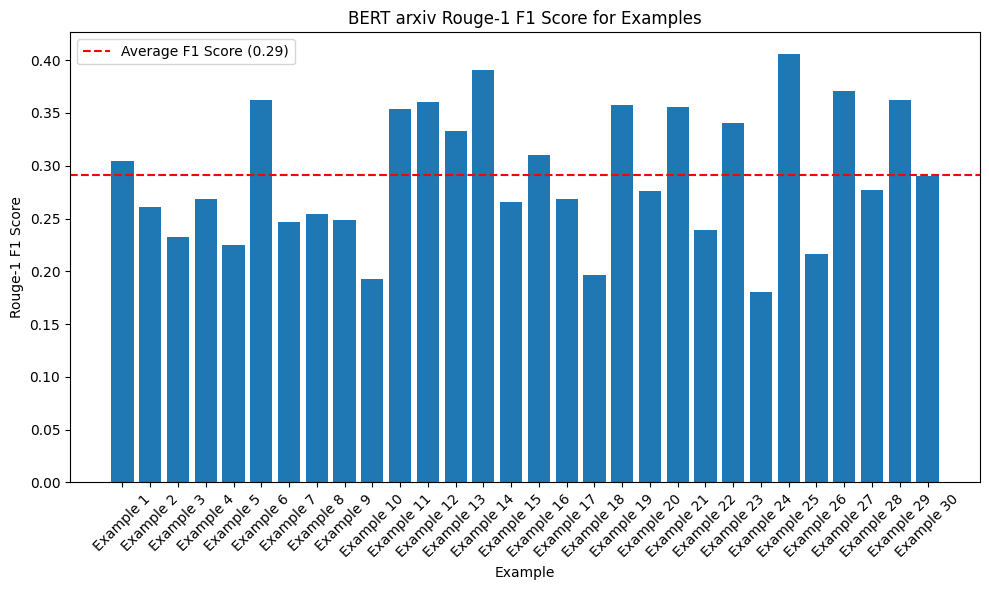

In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt


csv_file_path = os.path.join(output_dir, f"{formatted_model_name}_{dataset_name}_rouge_scores.csv")
rouge_df = pd.read_csv(csv_file_path)


average_rouge_1_f1 = rouge_df["Rouge-1 F1 Score"].mean()

# Plot the Rouge scores
plt.figure(figsize=(10, 6))
plt.bar(range(len(rouge_df)), rouge_df["Rouge-1 F1 Score"], tick_label=[f"Example {i+1}" for i in range(len(rouge_df))])
plt.axhline(y=average_rouge_1_f1, color='r', linestyle='--', label=f"Average F1 Score ({average_rouge_1_f1:.2f})")
plt.xlabel("Example")
plt.ylabel("Rouge-1 F1 Score")
plt.title(f"BERT {dataset_name} Rouge-1 F1 Score for Examples")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
output_file_name = "Rouge-1_F1_Pegasus_arxiv"
save_path = os.path.join("/content/bert-base-uncased_arxiv_evaluation/rouge/", output_file_name)

plt.savefig(save_path)
# Show the plot
plt.show()

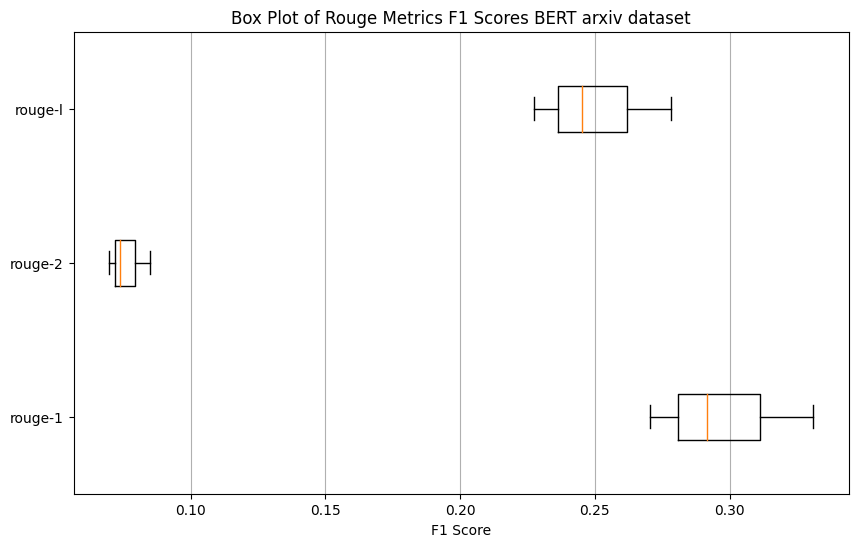

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the average_rouge_df from the CSV file
average_rouge_df = pd.read_csv(os.path.join(output_dir, f"{formatted_model_name}_{dataset_name}_average_rouge_scores.csv"))

# Define the Rouge metrics you want to plot
rouge_metrics = ["rouge-1", "rouge-2", "rouge-l"]


plt.figure(figsize=(10, 6))
plt.boxplot([average_rouge_df[metric] for metric in rouge_metrics], vert=False)
plt.title(f"Box Plot of Rouge Metrics F1 Scores BERT {dataset_name} dataset")
plt.xlabel("F1 Score")
plt.yticks(range(1, len(rouge_metrics) + 1), rouge_metrics)
plt.grid(axis='x')

output_file_name = "Rouge-1_2_l_Boxplot_pegasus_arXiv"
save_path = os.path.join(f"/content/bert-base-uncased_{dataset_name}_evaluation/rouge", output_file_name)

plt.savefig(save_path)
plt.show()

In [41]:
bleu_scores = []
meteor_scores = []
total_bleu_score = 0.0
total_meteor_score = 0.0

In [42]:
for i, example in enumerate(test_dataset):
    if i >= 30:
        break

    article = example["article"]
    abstract = example["abstract"]

    # Generate a summary using the sliding_window_summarization function
    summary =extractive_summarization(article, model=model, tokenizer=tokenizer, summary_length = 5 ,device = device )

    # Calculate BLEU and METEOR scores (continue as before)
    reference = abstract.split()  # Tokenized reference
    hypothesis_tokens = summary.split()  # Tokenized hypothesis for both BLEU and METEOR
    bleu_score = sentence_bleu([reference], hypothesis_tokens)

    bleu_scores.append(bleu_score)
    total_bleu_score += bleu_score

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [43]:
# Calculate average scores
average_bleu_score = total_bleu_score / num_examples_to_evaluate

In [44]:
os.makedirs(f'{model_name}_{dataset_name}_evaluation/bleu', exist_ok=True)

In [45]:
bleu_df = pd.DataFrame(bleu_scores, columns=["BLEU Score"])

bleu_output_dir = os.path.join(f"/content/{model_name}_{dataset_name}_evaluation", "bleu")

os.makedirs(bleu_output_dir, exist_ok=True)


bleu_df.to_csv(os.path.join(bleu_output_dir, f"{formatted_model_name}_{dataset_name}_bleu_scores.csv"), index=False)

print("Average BLEU Score:", average_bleu_score)


Average BLEU Score: 0.03098820571121165


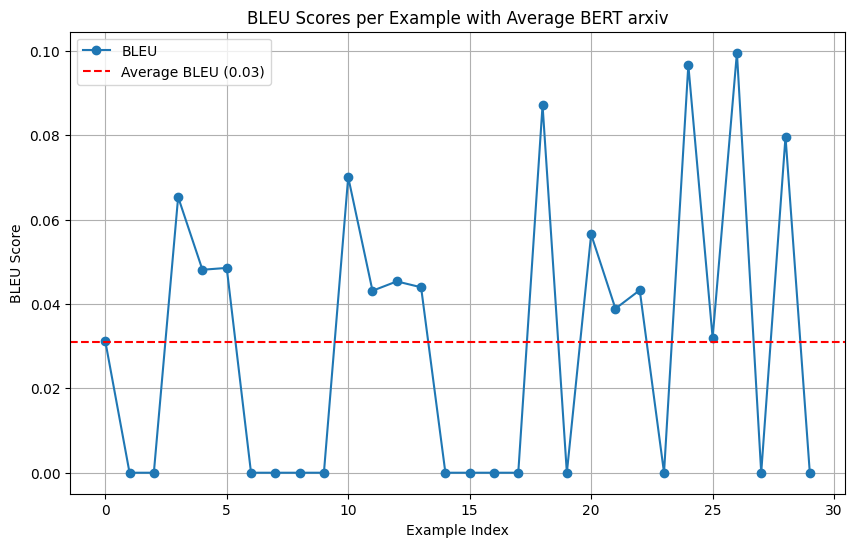

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(bleu_scores, marker='o', linestyle='-', label='BLEU')
plt.axhline(y=average_bleu_score, color='r', linestyle='--', label=f'Average BLEU ({average_bleu_score:.2f})')
plt.title(f'BLEU Scores per Example with Average BERT {dataset_name}')
plt.xlabel('Example Index')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.legend()
plt.show()